In [1]:
import os
import glob
os.chdir('/workdir')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["SM_FRAMEWORK"] = "tf.keras"

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import netCDF4 as nc
import numpy as np
import pandas as pd

import tqdm
from scipy.stats import qmc

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import joblib
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from cmaqnet.alloc import allocation, const_allocation

In [3]:
SEASON = ['January', 'April', 'July', 'October']
CTRL_KEY_LIST = ['ALL_POW','ALL_IND','ALL_MOB','ALL_RES','NH3_AGR','ALL_SLV','ALL_OTH']
EMIS_KEY = ['SO2', 'NH3', 'VOCs', 'CO', 'PM2_5', 'NOx']
CONC_KEY = ['PM2.5_SO4', 'PM2.5_NH4', 'PM2.5_NO3', 'PM2.5_Total']#, 'O3']
REGION_CODE = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'
}

alloc_df = pd.DataFrame(allocation, columns=['Region_Name', 'Region_Code', 'Row', 'Column', 'Ratio'])
const_alloc_df = pd.DataFrame(const_allocation, columns=['Region_Name', 'Region_Code', 'Row', 'Column', 'Ratio'])

TARGET='NOx'
TARGET_IDX=EMIS_KEY.index(TARGET)
INDEX=1

ctrl = pd.read_csv('/workdir/datasets/control_matrix.csv', index_col=0)
emis_path = [sorted(glob.glob(f'/dataset/npy/emis/hourly_new_split/RSM_{i}/*.npy')) for i in range(1, 120)]

slices = [slice(0, 41*24), slice(41*24, 81*24), slice(81*24, 122*24), slice(122*24, 163*24)]
starting_idx = [0, 49*24, 49*24+51*24, 49*24+51*24+51*24]
timelength = [41*24, 40*24, 41*24, 41*24]

emis_dataset = np.load(f'/workdir/datasets/emis_all_1.npy')

ctrl_dataset = []
time_dataset = []
date = list(range(timelength[INDEX]))
for i in range(119):
    if i == 116:
        continue
    time_dataset.append(date.copy())
    ctrl_dataset.append([ctrl.values[i] for _ in range(len(date))])
ctrl_dataset = np.array(ctrl_dataset).squeeze()
time_dataset = np.array(time_dataset).astype(np.float32)

X_ctrl_train, X_ctrl_test, X_time_train, X_time_test, y_train, y_test = train_test_split(
    ctrl_dataset, time_dataset, emis_dataset, train_size=60, random_state=42, shuffle=True)

In [9]:
def moving_average(data, window_size, axis=1):
    weights = np.repeat(1.0, window_size) / window_size
    moving_avg = np.apply_along_axis(lambda m: np.convolve(m, weights, mode='valid'), axis=axis, arr=data)
    return moving_avg

In [ ]:
y_train_hour = moving_average(y_train.reshape(-1, 40, 24, 6, 82, 67), 8, axis=2).max(axis=2)

In [5]:
y_test_hour = moving_average(y_test.reshape(-1, 40, 24, 6, 82, 67), 8, axis=2).max(axis=2)

In [6]:
y_train_hour_emis = y_train_hour[:, :, (2, 5), :, :]
y_test_hour_emis = y_test_hour[:, :, (2, 5), :, :]

In [7]:
X_ctrl_train.shape, y_train_hour_emis.shape

((60, 960, 119), (60, 40, 2, 82, 67))

In [8]:
lasso_emis = Lasso(alpha=0.001).fit(X_ctrl_train[:, 0], y_train_hour_emis[:, 3].reshape(-1, 2*82*67))
pred_emis = lasso_emis.predict(X_ctrl_test[:, 0]).reshape(-1, 2, 82, 67)

In [9]:
xgb_emis = XGBRegressor(
    eval_metric='rmse',
    n_jobs=-1).fit(X_ctrl_train[:, 0], y_train_hour_emis[:, 3].reshape(-1, 2*82*67), verbose=1)
pred_emis = xgb_emis.predict(X_ctrl_test[:, 0]).reshape(-1, 2, 82, 67)

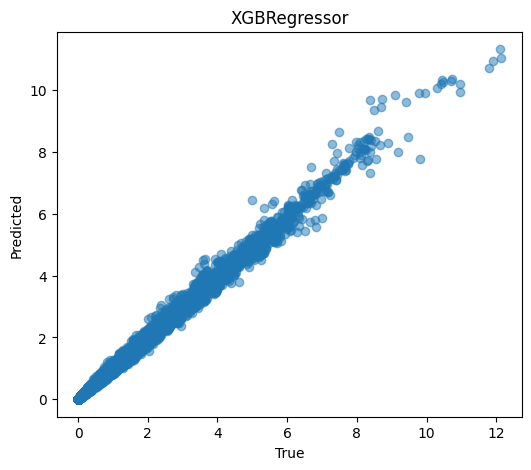

In [10]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test_hour_emis[:, 3].reshape(-1, 2*82*67), pred_emis.reshape(-1, 2*82*67), alpha=0.5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('XGBRegressor')
plt.show()

In [4]:
class SMOKELasso(object):
    def __init__(self, t_len):
        self.t_len = t_len
        self.models = [Lasso(alpha=1e-3) for _ in range(t_len)]

    def fit(self, X, y):
        for i in range(self.t_len):
            print(f'Fitting model {i+1}/{self.t_len}', end='\r')
            self.models[i].fit(X[:, i], y[:, i])
        return self

    def predict(self, X):
        return np.array(
            [model.predict(X[:, i]) for i, model in enumerate(self.models)]
        ).transpose(1, 0, 2)
    
    def save(self, path):
        joblib.dump(self.models, path)
        return self

    def load(self, path):
        self.models = joblib.load(path)
        return self

# model = SMOKELasso(40)
# model = model.fit(X_ctrl_train, y_train_hour)
# model = model.save(f'/workdir/models/emis/lasso_{TARGET}_{INDEX}.joblib')

In [5]:
import tensorflow as tf

model_o3_1 = tf.keras.models.load_model('/workdir/models/cond_unet_o3_all_attn')
model_vocs_1 = SMOKELasso(40).load('/workdir/models/emis/lasso_VOCs_1.joblib')
model_nox_1 = SMOKELasso(40).load('/workdir/models/emis/lasso_NOx_1.joblib')
X_met = np.load('/workdir/datasets/interpolated_meteo_v2.npy')

grid_info = pd.read_csv('/workdir/datasets/grid_allocation.csv')
total_grid = grid_info.loc[:, ['Row', 'Column']] - 1

In [6]:
# 2013   1st day 00:00 ~ 2013  31th day 23:00; Jan, Winter, 31 days (trained)
# 2013  32nd day 00:00 ~ 2013  83th day 23:00;   -,      -, 52 days (interpolated)
# 2013  84st day 00:00 ~ 2013 120th day 23:00; Mar, Spring, 37 days (trained)
# 2013 121st day 00:00 ~ 2013 174th day 23:00;   -,      -, 54 days (interpolated)
# 2013 175st day 00:00 ~ 2013 212th day 23:00; Jun, Summer, 38 days (trained)
# 2013 213st day 00:00 ~ 2013 266th day 23:00;   -,      -, 54 days (interpolated)
# 2013 267st day 00:00 ~ 2013 304th day 23:00; Sep,   Fall, 38 days (trained)
# 2013 305st day 00:00 ~ 2013 365th day 23:00;   -,      -, 61 days (extrapolated)

offset = 10*24

train_time = [31*24, 37*24, 38*24, 38*24]
inter_time = [52*24, 54*24, 54*24, 61*24]

train_i_idx = [
    0 + offset,
    train_time[0] + inter_time[0] + offset,
    train_time[0] + inter_time[0] + train_time[1] + inter_time[1] + offset,
    train_time[0] + inter_time[0] + train_time[1] + inter_time[1] + train_time[2] + inter_time[2] + offset
]
inter_i_idx = [
    train_time[0] + offset,
    train_time[0] + inter_time[0] + train_time[1] + offset,
    train_time[0] + inter_time[0] + train_time[1] + inter_time[1] + train_time[2] + offset,
    train_time[0] + inter_time[0] + train_time[1] + inter_time[1] + train_time[2] + inter_time[2] + train_time[3] + offset
]

timelength = [
    np.array(list(range(train_i_idx[0], train_i_idx[0]+train_time[0])), dtype=np.float32).reshape(-1, 1),
    np.array(list(range(inter_i_idx[0], inter_i_idx[0]+inter_time[0])), dtype=np.float32).reshape(-1, 1),
    np.array(list(range(train_i_idx[1], train_i_idx[1]+train_time[1])), dtype=np.float32).reshape(-1, 1),
    np.array(list(range(inter_i_idx[1], inter_i_idx[1]+inter_time[1])), dtype=np.float32).reshape(-1, 1),
    np.array(list(range(train_i_idx[2], train_i_idx[2]+train_time[2])), dtype=np.float32).reshape(-1, 1),
    np.array(list(range(inter_i_idx[2], inter_i_idx[2]+inter_time[2])), dtype=np.float32).reshape(-1, 1),
    np.array(list(range(train_i_idx[3], train_i_idx[3]+train_time[3])), dtype=np.float32).reshape(-1, 1),
    np.array(list(range(inter_i_idx[3], inter_i_idx[3]+inter_time[3])), dtype=np.float32).reshape(-1, 1),
]

In [7]:
num_samples = 100
ctrl_samples = qmc.LatinHypercube(d=119).random(n=num_samples)
ctrl_samples = qmc.scale(ctrl_samples, [0.0]*119, [2.0]*119)

In [10]:
pred_o3_all = []
for i in tqdm.tqdm(range(num_samples), desc='Predicting'):
    X_inputs = np.repeat(ctrl_samples[i:i+1], 24, axis=0)
    y_inputs = X_met[timelength[2][:24].astype(np.int32)].squeeze()
    pred_o3 = model_o3_1.predict(
        [X_inputs, y_inputs],
        batch_size=24, verbose=0)
    pred_o3 = np.exp(pred_o3 - 1) / 1000
    pred_o3 = pred_o3.reshape(-1, 24, 82, 67)
    pred_o3 = moving_average(pred_o3, 8, axis=1).max(axis=1)
    pred_o3_all.append(pred_o3[0])
pred_o3_all = np.array(pred_o3_all)

Predicting: 100%|██████████| 100/100 [00:10<00:00,  9.22it/s]


In [11]:
base_o3 = model_o3_1.predict(
    [np.ones((24, 119)), X_met[timelength[2][:24].astype(np.int32)].squeeze()],
    batch_size=24, verbose=0)
base_o3 = np.exp(base_o3 - 1) / 1000
base_o3 = base_o3.reshape(-1, 24, 82, 67)
base_o3 = moving_average(base_o3, 8, axis=1).max(axis=1)
pred_o3_ratio = (pred_o3_all + 1e-5) / (base_o3 + 1e-5)

In [12]:
voc_model = model_vocs_1.models[2]
nox_model = model_nox_1.models[2]

pred_vocs_all = voc_model.predict(
    ctrl_samples.reshape(-1, 119)
).reshape(num_samples, 82, 67, 1)
base_vocs = voc_model.predict(
    np.ones((1, 119))
).reshape(1, 82, 67, 1)
pred_vocs_ratio = (pred_vocs_all + 1e-5) / (base_vocs + 1e-5)

pred_nox_all = nox_model.predict(
    ctrl_samples.reshape(-1, 119)
).reshape(num_samples, 82, 67, 1)
base_nox = nox_model.predict(
    np.ones((1, 119))
).reshape(1, 82, 67, 1)
pred_nox_ratio = (pred_nox_all + 1e-5) / (base_nox + 1e-5)

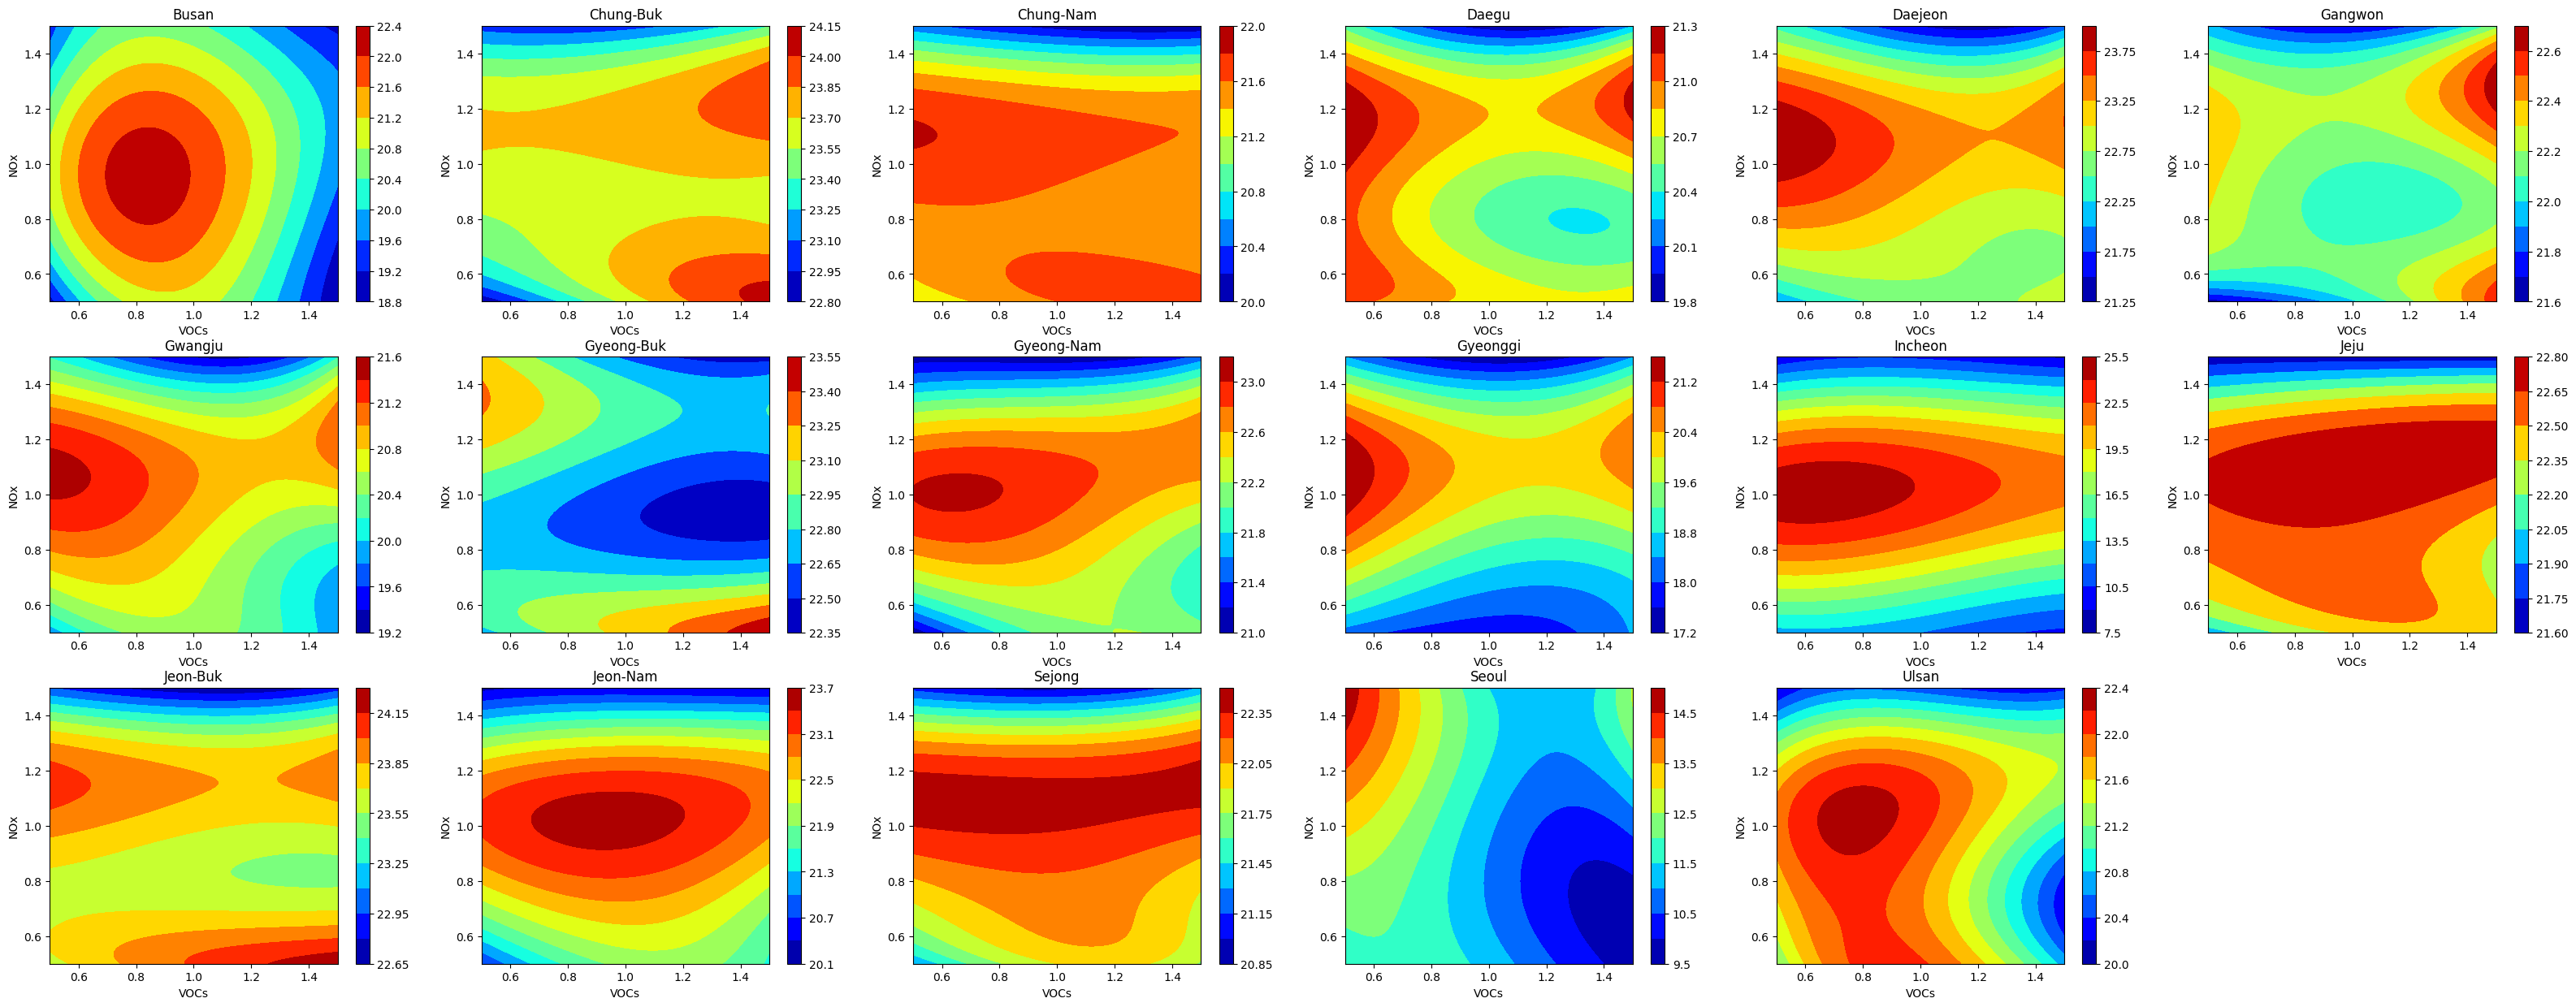

In [20]:
from scipy.optimize import curve_fit

# def rsm(x, *popt):
#     ret = popt[0] * x[0] + popt[1] * x[0]**2
#     ret += popt[2] * x[1] + popt[3] * x[1]**2
#     ret += popt[4] * x[0] * x[1]
#     ret += popt[5] * x[0]**2 * x[1] + popt[6] * x[0] * x[1]**2
#     ret += popt[7] * x[0]**2 * x[1]**2
#     return ret

n = 2
def rsm(x, *popt):
    ret = 0
    for i in range(n):
        for j in range(n):
            ret += popt[i*n+j] * x[0]**(i+1) * x[1]**(j+1)
    return ret

def rsm(x, *popt):
    ret = 0
    ret += popt[0] * x[0] + popt[1] * x[0]**2 + popt[2] * x[0]**3
    ret += popt[3] * x[1] + popt[4] * x[1]**2 + popt[5] * x[1]**3 + popt[6] * x[1]**4 + popt[7] * x[1]**5
    ret += popt[8] * x[0] * x[1]
    ret += popt[9] * x[0]**3 * x[1]
    ret += popt[10] * x[0] * x[1]**2
    ret += popt[11] * x[0] * x[1]**5
    return ret

resolution = 1000
xmin, xmax = 0.5, 1.5
x_range = np.linspace(xmin, xmax, resolution)
y_range = np.linspace(xmin, xmax, resolution)
grid_x, grid_y = np.meshgrid(x_range, y_range)

plt.figure(figsize=(40, 15))
region_grp = grid_info.groupby('Region_Name')
for i, (name, region) in enumerate(region_grp):
    region_grid = (region.loc[:, ['Row', 'Column']] - 1).reset_index(drop=True)
    row, col = region_grid.Row, region_grid.Column
    res = pd.DataFrame({
        'O3': (
            abs(pred_o3_all[:, row, col]
                .reshape(-1))
                .squeeze()*1000),
        'VOCs': (
            abs(pred_vocs_ratio[:, row, col])
                .reshape(-1)
                .squeeze()),
        'NOx': (
            abs(pred_nox_ratio[:, row, col])
                .reshape(-1)
                .squeeze())
    })

    popt, pcov = curve_fit(
        rsm, res[['VOCs', 'NOx']].values.T, res['O3'].values,
        p0=np.random.normal(0, 1, 13),
        maxfev=100000)

    z = rsm([grid_x, grid_y], *popt)
    plt.subplot(3, 6, i+1)

    plt.title(name)
    plt.contourf(grid_x, grid_y, z, levels=10, cmap='jet')
    plt.colorbar()
    plt.xlabel('VOCs')
    plt.ylabel('NOx')

plt.show()